# Introducción: Redes Siamesas

En este proyecto vamos a explorar el desarrollo y entrenamiento de una red siamesa de clasificación.
Estas redes se definen al crear relaciones entre un par de imagenes de entrada y dan como resultado una calificación de relación entre estas imágenes.

Las redes siamesas se distinguen por ser un modelo de enrenamiento que tiene dos ramas completamene iguales de capas de neuronas que se unen al momento de evaluar la relación de las entradas.
Técnicamente el modelo se entrena de modo paralelo y al final compara conclusiones.

Este tipo de modelo nos permite clasificar la relación entre does imagenes, puede funcionar para verificación facial, categorización de ropa y hasta en reconocimiento de firmas flasificadas.

Para este proyecto entrenaremos al modelo a distinguir pares de imagenes de ropa y que evalúe si similitud usando una métrica ecludiana.

Para la realización de este proyecto haremos lo siguiente:

1. Importación de librerías
2. Definimos funciones para tratar los pares de imagenes para el entrenamiento y extraemos data a utilizar.
3. Construimos modelo siamés
4. Definimos función de pérdida y entrenamos el modelo
5. Validamos funcionamiento de nuestro modelo


# 1. Importación de librerías

Instalamos e importamos librerías que serán usadas en el proyecto.
En este caso necesitaremos tensorflow para la construir nuestro modelo, numpy para la creación de arrays y matplotlip para graficar métricas
En este caso también instalaremos graphviz para representar la estructura de nuestro modelo a través de una imagen.

In [1]:
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

# 2. Definimos funciones para tratar la data

En esta sección vamos a definir funciones que nos ayuden a categorizar las imagenes, crear pares y asignarles una etiqueta de similitud.
Este paso es muy importante ya que aqui brindamos al modelo que imagenes tienen similitudes y cuales no.

En base a esta fórmulas el modelo va a aprender de las similitudes de las imagenes o diferencias.

In [4]:
# Definimos una función para crear pares de imagenes y sus "labels"
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1 #Aseguramos que tener la misma cantidad de pares por categoría
    for d in range(10): #Loop por cada categoría
        for i in range(n): #Hace loop dentro de cada catergoría
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1] #Creamos pares positivos
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10) #Creamos pares negativos
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i] 
            pairs += [[x[z1], x[z2]]]
            labels += [1,0]
    return np.array(pairs), np.array(labels)

In [5]:
# Definimos función para preparar la data y entrenar una red siamesa
def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

In [6]:
# Extraemos data con imagenes para entrenamiento
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images / 255
test_images = test_images / 255

train_pairs, train_labels = create_pairs_on_set(train_images, train_labels)
test_pairs, test_labels = create_pairs_on_set(test_images, test_labels)

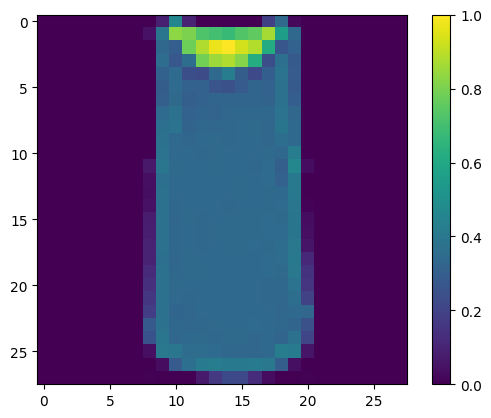

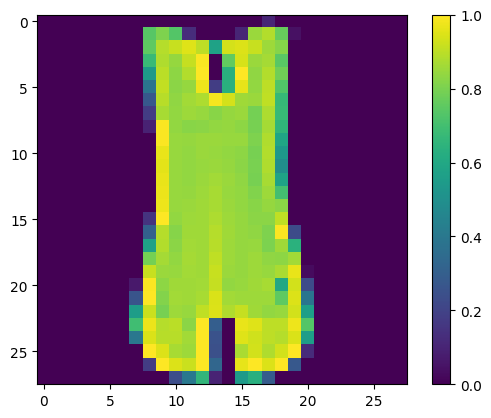

1.0


In [ ]:
# aqui mostramos como quedan emparejadas las imagenes, vemos un ejemplo de un par de imagenes que son similares
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()
this_pair = 2
show_image(train_pairs[this_pair][0])
show_image(train_pairs[this_pair][1])
print(train_labels[this_pair])

# 3. Construcción de nuestro modelo

En esta sección vamos a definir fórmulas que nos ayudan a construir nuestro modelo.
Construiremos el modelo capa por capa, cada rama por separado y al final los unimos a través del output deseado.

In [ ]:
# Construimos el modelo base usando capas de entrenamiento, este modelo se va a duplicar y va a trabajar en paralelo con pares los pares de imagenes
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    flatten = Flatten(name="flatten_input")(input)
    dense_1 = Dense(128, activation='relu', name="first_base_dense")(flatten)
    dropout_1 = Dropout(0.1, name="first_dropout")(dense_1)
    dense_2 = Dense(128, activation='relu', name="second_base_dense")(dropout_1)
    dropout_2 = Dropout(0.1, name="second_dropout")(dense_2)
    dense_3 = Dense(128, activation='relu', name="third_base_dense")(dropout_2)
    return Model(inputs=input, outputs= dense_3, name="base_network")

In [ ]:
# Definimos una fórmula para calcular la distancia ecluidiana entre el par de imagenes, esto nos va a paermitir medir que tan similares o distintas son
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
# Definimos una función con el margen de la distancia ecluidiana
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

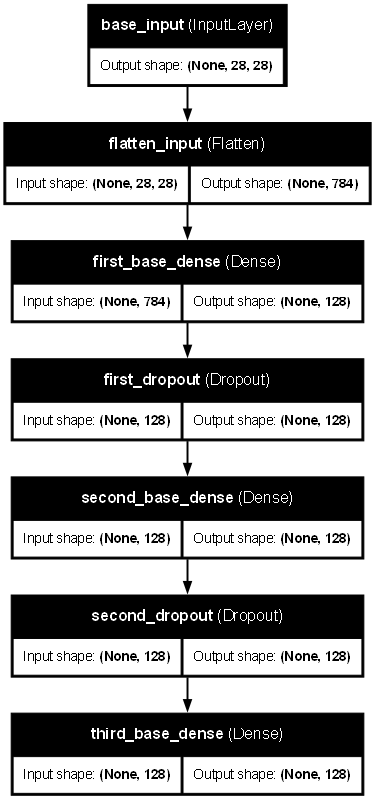

In [ ]:
# Creamos una imagen para visualizar como va a trabajar nuestro modelo base
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, dpi=70, to_file='model_base.png')

Aqui podemos observar que cada rama de nuestro modelo siames va a contar con 6 capas de entrenamiento, intercaladas las neuronas de entrenamiento y "dropouts".
Los "dropouts" nos funcionan para no sobre entrenar el modelo con un peso de neuronas recurrente, esto fuerza al modelo a buscar similitudes en cada capa del proceso.

In [ ]:
# Revisamos un resumen de nuestro modelo base, este nos indica los parámetros que utilizarña para entrenar y la capacidad que va a requerir el entrenamiento en KB
base_network.summary()

Model: "base_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ base_input (InputLayer)         │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_input (Flatten)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_base_dense (Dense)        │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_dropout (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_base_dense (Dense)       │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_dropout (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ third_base_dense (Dense)        │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,504 (521.50 KB)

 Trainable params: 133,504 (521.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Vamos a definir nuestros dos canales de entrada, este modelo va a requerir dos inputs. Uno por cada imagen dentro del par.
# Creamos las capas de input deseada y las unimos con un output que calcule la distancia ecluidiana entre el par de imagenes.
input_a = Input(shape=(28,28,), name="left_input")
output_a = base_network(input_a)
input_b = Input(shape=(28,28,), name="right_input")
output_b = base_network(input_b)

output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([output_a, output_b])
siamese_model = Model([input_a, input_b], output)

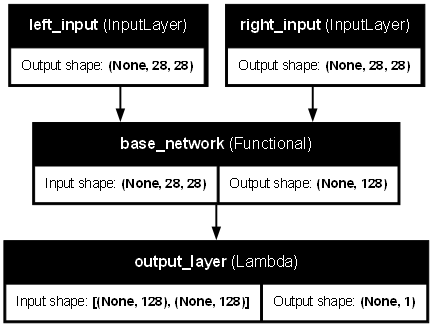

In [14]:
plot_model(siamese_model, show_shapes=True, dpi=70, show_layer_names=True, to_file='siames_model.png')

Al crear una imagen que represente la syntaxis de nuestro modelo, podemos observar que requiere dos inputs por separado, cada input va a pasar por un procesamiento de classificación y finalmente se une debtro del output para medir la similitud entre el par de imagenes.

# 4. Definimos función de pérdida y entrenamos el modelo

En esta sección creamos una función de pérdida de contraste de pérdida. En dónde pedimos al modelo que al momento de realizar el output de similitud máximise las similitudes y minimise las diferencia de las imagenes. De tal modo que minimizamos la distancia entre elemntos similares y maximizamos la distancia entre elementos distintos de las imagenes.

También definimos un optimizador basado en descenso de gradiante llamado RMSprop, este se ajsuta para no volverse muy pequeño usando un promedio de pesos de las últimas capas de tal modo que sea más eficiente y acorde a la última capa de entrenamiento.

In [ ]:
# Definimos métrica de error por contraste
def contrastive_loss_with_margin(margin):
    def contrastive_loss(output_true, output_pred):
        square_pred = K.square(output_pred)
        margin_square = K.square(K.maximum(margin - output_pred, 0))
        return K.mean(output_true * square_pred + (1- output_pred) * margin_square)
    return contrastive_loss

In [ ]:
# Definimos optimizador y lo integramos a nuestro modelo
rms = RMSprop()
siamese_model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

In [ ]:
# Entrenamos nuestro modelo
history = siamese_model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels, epochs=20, batch_size=128, validation_data=([test_pairs[:,0], test_pairs[:,1]], test_labels))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1976 - val_loss: 0.2071
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1977 - val_loss: 0.2086
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1975 - val_loss: 0.2055
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1968 - val_loss: 0.2086
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1972 - val_loss: 0.2064
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1980 - val_loss: 0.2067
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1964 - val_loss: 0.2064
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1973 - val_loss: 0.2081
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1969 - val_loss: 0.2068
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1980 - val_loss: 0.2071
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1964 - val_loss: 0.2064
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

In [ ]:
# Vemos cual es la desviación estandar de nuestro modelo de predicción
loss = siamese_model.evaluate(x=[test_pairs[:,0], test_pairs[:,1]], y=test_labels)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2099


# 5. Validamos funcionamiento de nuestro modelo

En esta sección vamos a definir métricas de valuación y usaremos predicciones para medir nuestro modelo.
Queremos ver que tan apegado es el modelo a las etiquetas que asignamos a los pares de imagenes.

In [ ]:
# Definimos porcentaje de precisión de nuestro modelo según los objetivos
def compute_accuracy(labels_true, labels_pred):
    pred = labels_pred.ravel() > 0.5
    return np.mean(pred == labels_true)

In [ ]:
# Hacemos predicciones sobre nuestro modelo y lo comparamos con las etiquetas asignadas
pred_train = siamese_model.predict([train_pairs[:,0], train_pairs[:,1]])
train_accuracy = compute_accuracy(train_labels, pred_train)

pred_test = siamese_model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_labels, pred_test)

print("Loss = {}, Train Accuracy = {}, Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step
Loss = 0.20730644464492798, Train Accuracy = 0.057942990498416405, Test Accuracy = 0.10270270270270271


In [ ]:
# Definimos función para graficar el proceso de iteración sobre las épocas dentro del modelo
def plot_metrics(metric, title, ylim=5):
    plt.title(title)
    plt.ylim(0.18, ylim)
    plt.plot(history.history[metric], color='blue', label=metric)
    plt.plot(history.history['val_' + metric], color='green', label='val_' + metric)

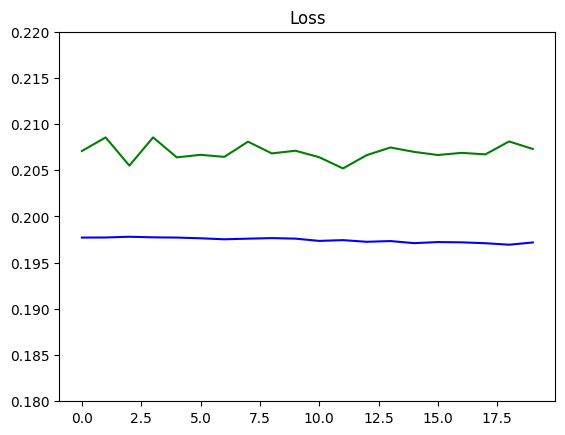

In [44]:
plot_metrics(metric='loss', title="Loss", ylim=0.22)

Podemos observar en la línea azul que la iteración sobre el entrenamiento se mantiene estable, teniendo un error promedio similar por época.
En la línea vemos que al momento de testaer nuestro modelo con el dataset de validación, este tiene más fluctuaciones en el error y es un poco mayor que en el entrenamiento.

In [ ]:
# Definimos funciones para visualizar imagenes de manera gráfica que nos muestren 10 pares de imagenes al azar y nos digan cuanta sea la similitid de cada imagen.
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('figure', facecolor='F0F0F0')

def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red')
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)


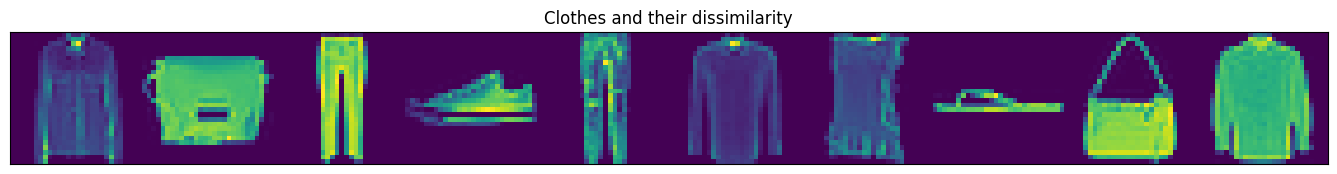

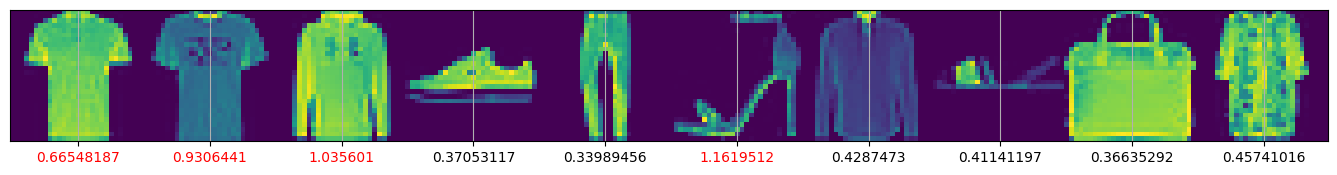

In [56]:
pred_train = np.squeeze(pred_train)
indexes = np.random.choice(len(pred_train), size=10)
display_images(train_pairs[:,0][indexes], train_pairs[:,1][indexes], pred_train[indexes], train_labels[indexes], "Clothes and their dissimilarity", 10)

Podemos observar que mientras más similares ean las imagenes, menor será el score de distancia.
Los pares de imagenes que tengan una distancia menor a 0.5 son más similares, las que sean mayores a 0.5 ya empiezan a tener diferencia significativas

# Conclusiones

Este ejericio nos ayuda a entender como se crea y se entrena una red siamesa.
Esta nos ayuda a validar similitudes entre pares de imagenes creando una categorización y clasificación más sencilla.
En este caso ingresamos varios inputs y conseguimos 1 output que nos enseñe la similitud entre un par de imagenes.